<a href="https://colab.research.google.com/github/mnoorchenar/SmartMeterData/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# !pip install livelossplot

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from livelossplot import PlotLossesKerasTF

In [34]:
# load data into pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/SmartMeterData/utilismart_cleaned.csv')

# set "READTS" as the index of the dataframe
df["READTS"] = pd.to_datetime(df["READTS"], format="%Y-%m-%d %H:%M:%S")
df.set_index("READTS", inplace=True)

df.head()

,VAL
READTS,
2021-01-01 05:00:00,0.0205
2021-01-01 05:15:00,0.0200
2021-01-01 05:30:00,0.0200
2021-01-01 05:45:00,0.0205
2021-01-01 06:00:00,0.0200


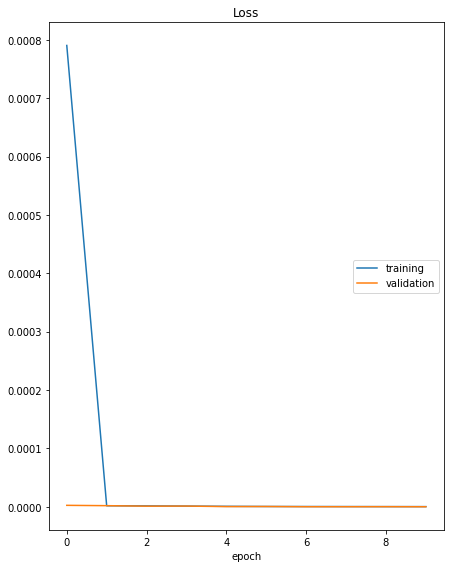

Loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
2622/2622 [==============================] - 9s 3ms/step


In [35]:
# extract the year from the "READTS" column
df["year"] = df.index.year

# split the data into training and test sets based on year
train = df[df["year"] < 2022]
test = df[df["year"] >= 2022]

# normalize the "VAL" column using MinMaxScaler
scaler = MinMaxScaler()
train["VAL"] = scaler.fit_transform(train["VAL"].values.reshape(-1, 1))
test["VAL"] = scaler.transform(test["VAL"].values.reshape(-1, 1))

# reshape the data for LSTM
X_train = np.reshape(train.values, (train.shape[0], train.shape[1], 1))
X_test = np.reshape(test.values, (test.shape[0], test.shape[1], 1))
y_train = train["VAL"]
y_test = test["VAL"]

# create a sequential model
model = Sequential()

# add an LSTM layer
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))

# add a dense layer with a single output
model.add(Dense(1))

# compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

# train the model and plot the loss live
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[PlotLossesKerasTF()])

# make predictions on the test data
y_pred = model.predict(X_test)

# inverse transform the predictions back to the original scale
y_pred = scaler.inverse_transform(y_pred)


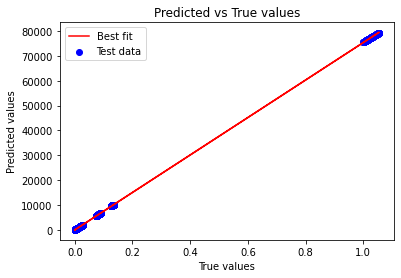

In [36]:
import matplotlib.pyplot as plt

# create a scatter plot of the predicted values and the true values
plt.scatter(y_test, y_pred, c="blue", label="Test data")

# add labels and a title to the plot
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Predicted vs True values")

# add a line of best fit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, c="red", label="Best fit")

# add a legend to the plot
plt.legend()

# show the plot
plt.show()
